In [26]:
import numpy as np
from numpy import pi, r_
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import xlrd
import os

### Simulation Element Functions
##
#

def elem_L(w, L):
    '''
    Simulation Function: -L-
    Returns the impedance of an inductor
    
    Kristian B. Knudsen (kknu@berkeley.edu || kristianbknudsen@gmail.com)
    
    Inputs
    ----------
    w = Angular frequency [1/s]
    L = Inductance [ohm * s]
    '''
    return 1j*w*L

def elem_C(w,C):
    '''
    Simulation Function: -C-
    
    Inputs
    ----------
    w = Angular frequency [1/s]
    C = Capacitance [F]    
    '''
    return 1/(C*(w*1j))

def elem_Q(w,Q,n):
    '''
    Simulation Function: -Q-
    
    Inputs
    ----------
    w = Angular frequency [1/s]
    Q = Constant phase element [s^n/ohm]
    n = Constant phase elelment exponent [-]
    '''
    return 1/(Q*(w*1j)**n)

def Randles_coeff_simple(w, sigma):
    '''
    Returns the Randles coefficient sigma [ohm/s^1/2]. 
    Two cases: a) ox and red are both present in solution here both Cred and Dred are defined, b) In the particular case where initially
    only Ox species are present in the solution with bulk concentration C*_ox, the surface concentrations may be calculated as function
    of the electrode potential following Nernst equation. Here C_red and D_red == 'none'
    
    Ref.:
        - Lasia, A.L., ISBN: 978-1-4614-8932-0, "Electrochemical Impedance Spectroscopy and its Applications" 
        - Bard A.J., ISBN: 0-471-04372-9, Faulkner L. R. (2001) "Electrochemical methods: Fundamentals and applications". New York: Wiley.
    Kristian B. Knudsen (kknu@berkeley.edu // kristianbknudsen@gmail.com)
    
    Inputs
    ----------

    
    Returns
    ----------
    Randles coefficient [ohm/s^1/2]
    '''
    Z_Aw = sigma*(w**(-0.5))-1j*sigma*(w**(-0.5))
    return Z_Aw

def cir_Randles(w, Rs, Rct, n, Q, sigma):
    '''
    Simulation Function: Randles -Rs-(Q-(RW)-)-
    Return the impedance of a Randles circuit with full complity of the warbug constant
    NOTE: This Randles circuit is only meant for semi-infinate linear diffusion
    Kristian B. Knudsen (kknu@berkeley.edu / kristianbknudsen@gmail.com)
    
    Inputs
    ----------
    n_electron = number of e- [-]
    A = geometrical surface area [cm2]
    D_ox = Diffusion coefficent of oxidized specie [cm2/s]
    D_red = Diffusion coefficent of reduced specie [cm2/s]
    C_ox = Concetration of oxidized specie [mol/cm3]
    C_red = Concetration of reduced specie [mol/cm3]
    T = Temperature [K]
    Rg = Gas constant [J/molK]
    F = Faradays consntat [C/mol]
    E = Potential [V]
        if reduced specie is absent == 'none'
    E0 = Formal potential [V]
        if reduced specie is absent == 'none'
    Rs = Series resistance [ohm]
    Rct = charge-transfer resistance [ohm]
    Q = Constant phase element used to model the double-layer capacitance [F]
    n = expononent of the CPE [-]
    
    Returns
    ----------
    The real and imaginary impedance of a Randles circuit [ohm]
    '''
    Z_Rct = Rct
    Z_Q = elem_Q(w,Q,n)
    Z_w = Randles_coeff_simple(w, sigma)
    return Rs + 1/(1/Z_Q + 1/(Z_Rct+Z_w))

def cir_RQ_Randles(w, Rs, Rct1, n1, Q1, Rct2, n2, Q2, sigma):
    '''
    Simulation Function: Randles -Rs-(Q-(RW)-)-
    Return the impedance of a Randles circuit with full complity of the warbug constant
    NOTE: This Randles circuit is only meant for semi-infinate linear diffusion
    Kristian B. Knudsen (kknu@berkeley.edu / kristianbknudsen@gmail.com)
    
    Inputs
    ----------
    Rs = Series resistance [ohm]
    Rct = charge-transfer resistance [ohm]
    Q = Constant phase element used to model the double-layer capacitance [F]
    n = expononent of the CPE [-]
    
    Returns
    ----------
    The real and imaginary impedance of a Randles circuit [ohm]
    '''
    Z_Rct1 = Rct1
    Z_Rct2 = Rct2
    Z_Q1 = elem_Q(w,Q1,n1)
    Z_Q2 = elem_Q(w,Q2,n2)
    Z_w = Randles_coeff_simple(w, sigma)
    return Rs + 1/(1/Z_Q1 + 1/(Z_Rct1)) + 1/(1/Z_Q2 + 1/(Z_Rct2+Z_w))

def cir_RQ_RQ(w, Rs, Rct1, n1, Q1, Rct2, n2, Q2):
    """
    Simulation Function: Randles -Rs-(Q-R)-(Q-R)-
    """
    Z_Rct1 = Rct1
    Z_Q1 = elem_Q(w,Q1,n1)
    Z_Rct2 = Rct2
    Z_Q2 = elem_Q(w,Q2,n2)
    return Rs + 1/(1/Z_Q1 + 1/Z_Rct1) + 1/(1/Z_Q2 + 1/Z_Rct2)
    
# a function opens a text file and returns as a dataframe
def txt_to_df_parstat(file_name):
    # open a text file from Parstat
    with open(file_name) as f:
        data = f.readlines()
        for i in range(len(data)):
            data[i] = data[i].rstrip("\n").split("\t")
            if i > 0:
                for j in range(len(data[i])):
                    if data[i][j] != "":
                        data[i][j] = float(data[i][j])
                    else:
                        data[i][j] = np.nan
    data_columns = data[0]
    data_points = data[1:]

    data_points_arr = np.array(data_points).T

    data_dict = {}
    for k in range(len(data_columns)):
        data_dict[data_columns[k]] = data_points_arr[k]
    df = pd.DataFrame(data_dict)
    return df

Number of points is 76


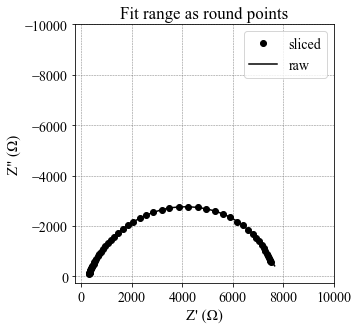

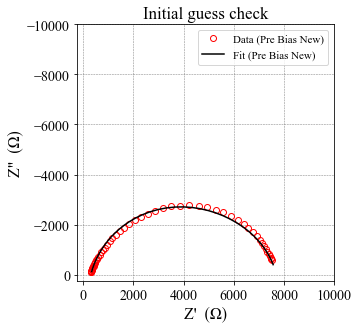

[332.56795319390085, 337.36579883923486, 342.9137606537952, 349.3404190983288, 356.79907181136235, 365.4729336671751, 375.58158123179123, 387.3887312411966, 401.21168025570347, 417.43281922294955, 436.5130429000918, 459.00836186416063, 485.5883644002289, 517.0578652851254, 554.3808238863022, 598.7054695495333, 651.3897605467533, 714.022383065497, 788.43692249506, 876.710295561894, 981.1388086871818, 1104.1760900833247, 1248.3260472619309, 1415.9744163741216, 1609.1593260767036, 1829.2804634974686, 2076.786562481885, 2350.873142656775, 2649.272606537241, 2968.2042356213524, 3302.53825313216, 3646.1804135623415, 3992.6140120682653, 4335.49805198505, 4669.187567370968, 4989.068679376927, 5291.674210002738, 5574.6067860152225, 5836.350822274519, 6076.066634125253, 6293.426725441004, 6488.532569361083, 6661.876960011673, 6814.3307471559465, 6947.113994417015, 7061.735096231324, 7159.904075357013, 7243.4300864609095, 7314.126678165, 7373.733234509889, 7423.858608505122, 7465.9496533342435, 7

In [42]:
######################################################################
#################### EDIT file_name AND ranges #######################
######################################################################

### Import data (copy/paste the file name) ###
file_name = 'Pre Bias New.csv'

### Decide the data range to fit ###
total_number_of_points = 76
start_cell = 15 # - if not slice
end_cell = total_number_of_points-5 # -1 if not slice


# initial guess - plot
Rs_guess = 300
Rct1_guess = 1400
n1_guess = 0.87
Q1_guess = 1.6e-5
Rct2_guess = 6000
n2_guess = 0.84
Q2_guess = 1.43e-06
sigma_guess = 0

# Plot range
x_high_lim = 10000

#######################################################################
###################### DO NOT EDIT BELOW ##############################
#######################################################################

file_type = ["GAMRY","DIELECTRIC SPECTROMETER","PARSTAT"] # please choose a file type you want to open
file_type_input = "PARSTAT"


if file_type_input == "GAMRY":
    data = pd.read_csv('Data/'+file_name, index_col=0)

    Freq = np.array(data.iloc[:,0])
    Ang_Freq = np.pi * Freq # Angular frequency
    Z_Real = np.array(data.iloc[:,1]) # Z'
    Z_Imag = np.array(-1*data.iloc[:,2]) # Z"
    Freq_np = np.array(Freq)

if file_type_input == "PARSTAT":
    if file_name.split(".")[-1]=="txt":
        # open a txt file 
        data = txt_to_df_parstat(file_name)
        Z_Real = np.array(data["Zre (ohms)"])
        Z_Imag = np.array(data["Zim (ohms)"])
        Freq = np.array(data["Frequency (Hz)"])
        Ang_Freq = np.pi * Freq # Angular frequency
    elif file_name.split(".")[-1]=="csv":
        data = pd.read_csv(file_name)
        Z_Real = data.iloc[:,1]
        Z_Imag = data.iloc[:,2]
        Freq = np.array(data.iloc[:,0])
        Ang_Freq = np.pi * Freq

print("Number of points is "+str(Ang_Freq.size))

Ang_Freq_slice = Ang_Freq[start_cell:end_cell]
Z_Real_slice = Z_Real[start_cell:end_cell]
Z_Imag_slice = Z_Imag[start_cell:end_cell]

### Plot both results ###

x_low_lim = -2.5/100*x_high_lim

y_high_lim = -1*x_high_lim
y_low_lim = -2.5/100*y_high_lim

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 5.2, 4.8

plt.title("Fit range as round points")
plt.plot(Z_Real_slice, Z_Imag_slice, 'ko', label='sliced')
plt.plot(Z_Real, Z_Imag, 'k-', label='raw')
plt.xlim(x_low_lim, x_high_lim)
plt.ylim(y_low_lim, y_high_lim)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.ylabel('Z\" (\u03A9)', fontsize=15)
plt.xlabel('Z\' (\u03A9)', fontsize=15)
plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.show()

Z_Real_circuit_guess = []
Z_Imag_circuit_guess = []

# change the function to fit!
for i in range(start_cell, end_cell):
    Z_Real_circuit_guess.append(cir_RQ_RQ(Ang_Freq[i], Rs_guess, Rct1_guess, n1_guess, Q1_guess, Rct2_guess, n2_guess, Q2_guess).real)
    Z_Imag_circuit_guess.append(cir_RQ_RQ(Ang_Freq[i], Rs_guess, Rct1_guess, n1_guess, Q1_guess, Rct2_guess, n2_guess, Q2_guess).imag)
    
plt.title("Initial guess check")
plt.plot(Z_Real_slice, Z_Imag_slice, "ro", markerfacecolor='None', label='Data ('+file_name[0:-4]+')')
plt.plot(Z_Real_circuit_guess, Z_Imag_circuit_guess, color="k",ls="-", label = 'Fit ('+file_name[0:-4]+')')
plt.legend(prop={'size': 11})
plt.ylabel('Z\"  (\u03A9)', fontsize=16)
plt.xlabel('Z\'  (\u03A9)', fontsize=16)
plt.xlim(x_low_lim, x_high_lim)
plt.ylim(y_low_lim, y_high_lim)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print(Z_Real_circuit_guess)

Chi-square is:  0.0004725861141045488 
 15    8.412991e-06
16    1.928796e-06
17    3.519764e-05
18    1.844905e-06
19    3.356226e-06
20    4.093961e-06
21    1.271712e-07
22    1.483250e-05
23    6.939341e-06
24    8.490374e-07
25    1.404660e-06
26    2.054731e-06
27    2.549485e-06
28    1.470724e-09
29    6.890569e-06
30    7.095266e-06
31    8.893166e-06
32    9.975412e-06
33    1.326767e-05
34    3.457752e-05
35    4.447147e-06
36    6.675148e-06
37    2.800962e-05
38    8.330557e-06
39    9.283944e-05
40    1.207621e-05
41    1.827161e-07
42    2.242153e-05
43    1.117532e-06
44    2.631678e-05
45    3.098358e-06
46    4.299868e-09
47    1.844629e-06
48    3.066951e-05
49    9.569567e-06
50    2.240982e-06
51    3.136466e-05
52    3.027723e-06
53    2.276052e-07
54    8.527341e-06
55    3.586505e-07
56    3.866321e-06
57    1.361338e-06
58    2.354784e-06
59    4.517366e-06
60    7.158306e-08
61    4.311104e-07
62    5.398269e-07
63    1.132581e-07
64    4.539172e-08
65    3.55

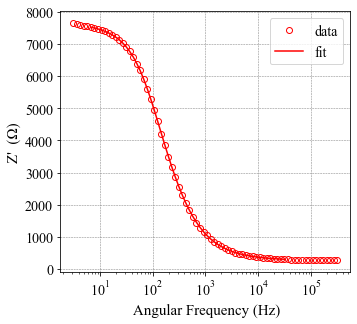

In [43]:
# initial guess - can be updated after 1st fitting
Rs = Rs_guess
Rct1 = Rct1_guess
n1 = n1_guess
Q1 = Q1_guess
Rct2 = Rct2_guess
n2 = n2_guess
Q2 = Q2_guess
initial_guess = np.array([Rs, Rct1, n1, Q1, Rct2, n2, Q2])


# Target function (Real)
fitfunc = lambda p, x: cir_RQ_RQ(x, p[0], p[1], p[2], p[3], p[4], p[5], p[6]).real # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
chi_sqr = lambda p, x, y: (errfunc(p, x, y)**2) / (fitfunc(p, x)**2)
# Initial guess for the first and second set's parameters
p0 = r_[Rs, Rct1, n1, Q1, Rct2, n2, Q2]
p1, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(Ang_Freq_slice, Z_Real_slice), \
    full_output=1, epsfcn=0.0001)

chi_square1 = sum(chi_sqr(p1, Ang_Freq_slice, Z_Real_slice))
print('Chi-square is: ', chi_square1, '\n', chi_sqr(p1, Ang_Freq_slice, Z_Real_slice))

# parameter errors
if (len(Z_Real_slice) > len(p0)) and pcov is not None:
    s_sq = (errfunc(p1, Ang_Freq_slice, Z_Real_slice)**2).sum()/(len(Z_Real_slice)-len(p0))
    pcov = pcov * s_sq
else:
    pcov = np.inf
print("pcov is: ", pcov)
param_error = [] 
for i in range(len(p1)):
    try:
        param_error.append(np.absolute(pcov[i][i])**0.5)
    except:
        param_error.append(0.00)
pfit1 = p1
perr1 = np.array(param_error) 

print("pfit = ", pfit1)
print("perr = ", perr1)

# Vector of the parameters to fit, it contains all the parameters of the problem, and the period of the oscillation is not there twice !
# p = r_[Rs, Rct, n, Q, sigma]

plt.plot(Ang_Freq, Z_Real, "ro", markerfacecolor='None', label='data')
plt.plot(Ang_Freq_slice, fitfunc(p1, Ang_Freq_slice), "r-", label='fit')
plt.ylabel('Z\'  (\u03A9)', fontsize=15)
plt.xlabel(' Angular Frequency (Hz)', fontsize=15)
plt.xscale('log')
plt.legend()
plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)
#print(p1)

pcov is:  inf
pfit =  [3.00000000e+02 6.70368399e+02 1.10628477e+00 8.11760618e-06
 6.87369296e+03 7.78767530e-01 2.65542634e-06]
perr =  [0. 0. 0. 0. 0. 0. 0.]
Chi-square is:  0.014924449612735088 
 15    1.653895e-03
16    9.012583e-04
17    1.313845e-04
18    1.543176e-04
19    1.614444e-04
20    3.789653e-04
21    3.658212e-06
22    1.943343e-05
23    1.060724e-05
24    1.048504e-05
25    1.215349e-05
26    5.105561e-05
27    1.687525e-09
28    7.026308e-06
29    2.661065e-06
30    1.332685e-05
31    1.846752e-05
32    1.876630e-05
33    1.046992e-05
34    2.926925e-05
35    1.581877e-05
36    1.803141e-05
37    1.290723e-05
38    8.891841e-06
39    7.361426e-05
40    1.192995e-05
41    6.891666e-06
42    8.322664e-06
43    6.063375e-07
44    4.617799e-06
45    9.403515e-07
46    3.428176e-07
47    3.480946e-06
48    5.392325e-06
49    3.933585e-07
50    3.438346e-06
51    1.107403e-05
52    1.109166e-05
53    6.240369e-07
54    7.923553e-06
55    1.999685e-05
56    4.596702e-07
57

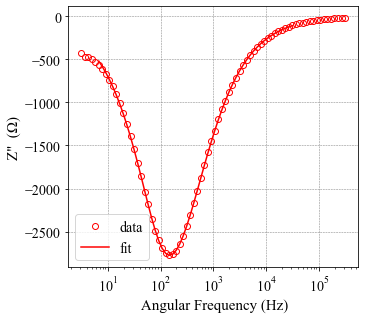

In [44]:
# Target function (Imag)
fitfunc = lambda p, x: cir_RQ_RQ(x, p[0], p[1], p[2], p[3], p[4], p[5], p[6]).imag # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
chi_sqr = lambda p, x, y: (errfunc(p, x, y)**2) / (fitfunc(p, x)**2)
# Initial guess for the first and second set's parameters
p0 = r_[Rs, Rct1, n1, Q1, Rct2, n2, Q2]
p2, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(Ang_Freq_slice, Z_Imag_slice), \
    full_output=1, epsfcn=0.0001)

# parameter errors
if (len(Z_Real_slice) > len(p0)) and pcov is not None:
    s_sq = (errfunc(p2, Ang_Freq_slice, Z_Imag_slice)**2).sum()/(len(Z_Imag_slice)-len(p0))
    pcov = pcov * s_sq
else:
    pcov = np.inf
print("pcov is: ", pcov)
param_error = [] 
for i in range(len(p1)):
    try:
        param_error.append(np.absolute(pcov[i][i])**0.5)
    except:
        param_error.append(0.00)
pfit2 = p2
perr2 = np.array(param_error) 

print("pfit = ", pfit2)
print("perr = ", perr2)

# Vector of the parameters to fit, it contains all the parameters of the problem, and the period of the oscillation is not there twice !
# p = r_[Rs, Rct, n, Q, sigma]

chi_square2 = sum(chi_sqr(p2, Ang_Freq_slice, Z_Imag_slice))
print('Chi-square is: ', chi_square2, '\n', chi_sqr(p2, Ang_Freq_slice, Z_Imag_slice))

plt.plot(Ang_Freq, Z_Imag, "ro", markerfacecolor='None', label='data')
plt.plot(Ang_Freq_slice, fitfunc(p2, Ang_Freq_slice), "r-", label='fit')
plt.ylabel('Z\"  (\u03A9)', fontsize=15)
plt.xlabel(' Angular Frequency (Hz)', fontsize=15)
plt.xscale('log')
plt.legend()
plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)

result params are
               Rs [Ω]     Rct1 [Ω]        n1        Q1 [F]     Rct2 [Ω]  \
Values    263.381180  2974.857323  0.943747  3.920446e-06  4434.394604   
Errors      3.646307  1076.629973  0.039393  8.631156e-07  1094.647583   
% Errors    1.384422    36.190978  4.174110  2.201575e+01    24.685390   

                n2        Q2 [F]  Chi-square  
Values    0.766207  3.419694e-06    0.000473  
Errors    0.006440  5.086891e-07    0.000473  
% Errors  0.840515  1.487528e+01    0.000473  
Directory already exists.


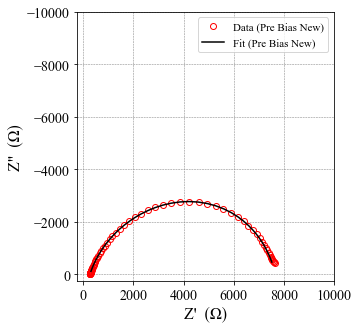

In [45]:
# Plot results in Nyquist plot
Rs = p1[0]
Rct1 = p1[1]
n1 = p1[2]
Q1 = p1[3]
Rct2 = p1[4]
n2 = p1[5]
Q2 = p1[6]

Z_Real_circuit = []
Z_Imag_circuit = []

for i in range(start_cell, end_cell):
    Z_Real_circuit.append(cir_RQ_RQ(Ang_Freq[i], Rs, Rct1, n1, Q1, Rct2, n2, Q2).real)
    Z_Imag_circuit.append(cir_RQ_RQ(Ang_Freq[i], Rs, Rct1, n1, Q1, Rct2, n2, Q2).imag)

# param labels to save as csv
param_labels = ['Rs [\u03A9]',\
                'Rct1 [\u03A9]',\
                'n1',\
                'Q1 [F]',\
                'Rct2 [\u03A9]',\
                'n2',\
                'Q2 [F]',\
                'Chi-square']

# params to save as csv
ps = [Rs,Rct1,n1,Q1,Rct2,n2,Q2]

# param error to save as csv
pe = perr1

# param % error to save as csv
ppe = []
for i in range(len(ps)):
    v = pe[i]/ps[i]*100
    ppe.append(v)

# chi sq
chsq = [chi_square1]*3

result_dicts = {}
for i in range(len(ps)):
    result_dicts[param_labels[i]] = [ps[i],pe[i],ppe[i]]
result_dicts[param_labels[len(ps)]] = chsq


result_params = pd.DataFrame(result_dicts, index=["Values","Errors","% Errors"])
print("result params are\n",result_params)

# make a directory with the same name as the file name
directory_name = file_name[0:-4]+" fit results"

try:
    os.mkdir(directory_name)
except FileExistsError:
    print('Directory already exists.')


# parameters save to csv
result_params.to_csv(directory_name+"/"+file_name[0:-4]+' parameters.csv')

# fit points save to csv
fit_points_dict = {}
fit_points_dict["Z_Real [\u03A9]"] = Z_Real_circuit
fit_points_dict["Z_Imag [\u03A9]"] = Z_Imag_circuit
fit_points_df = pd.DataFrame(fit_points_dict)
fit_points_df.to_csv(directory_name+"/"+file_name[0:-4]+' fit points.csv')

plt.plot(Z_Real, Z_Imag, "ro", markerfacecolor='None', label='Data ('+file_name[0:-4]+')')
plt.plot(Z_Real_circuit, Z_Imag_circuit, "k-", label = 'Fit ('+file_name[0:-4]+')')
plt.legend(prop={'size': 11})
plt.ylabel('Z\"  (\u03A9)', fontsize=16)
plt.xlabel('Z\'  (\u03A9)', fontsize=16)
plt.xlim(x_low_lim, x_high_lim)
plt.ylim(y_low_lim, y_high_lim)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.grid(b=None, which='major', axis='both', color='grey', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(directory_name+"/"+file_name[:-4]+' fit.png', dpi=300) # peak scale
plt.show()